In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os

from metrics import calculate_metrics

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/reproducible/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [14]:
import torch
def plot_batch_effect_ndreamer(dataset_name, cell_type_key, batch_key, condition_key):
    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_effct = []
    for filei in sorted(os.listdir("./" + dataset_name)):
        if filei.find("batch.h5ad") > 0:
            batch_effct.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    batch_effct = ad.concat(batch_effct, merge="same", uns_merge="same")

    # Process `batch_all` for denoised data
    batch_all_batch_effct = []
    for i in range(batch_effct.shape[0]):
        tmp = "__".join([batch_effct.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all_batch_effct.append(tmp)
    batch_all_batch_effct = np.array(batch_all_batch_effct)
    batch_effct.obs["batch_all"] = batch_all_batch_effct
    batch_effct.obs["batch_all"] = batch_effct.obs["batch_all"].astype("category")
    print("batch_all_denoise", np.unique(batch_all_batch_effct))

    # Process `batch_all_with_condition` for denoised data
    batch_all_with_condition_batch_effct = []
    for i in range(batch_effct.shape[0]):
        tmp = "__".join([batch_effct.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + batch_effct.obs[condition_key][i]
        batch_all_with_condition_batch_effct.append(tmp)
    batch_all_with_condition_batch_effct = np.array(batch_all_with_condition_batch_effct)
    batch_effct.obs["batch_all_with_condition"] = batch_all_with_condition_batch_effct
    batch_effct.obs["batch_all_with_condition"] = batch_effct.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition_denoise", np.unique(batch_all_with_condition_batch_effct))

    # batch_key.append("batch_all")
    # batch_key.append("batch_all_with_condition")

    denoised = []
    for filei in sorted(os.listdir("./" + dataset_name)):
        if filei.find("expression.h5ad") > 0:
            denoised.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    denoised = ad.concat(denoised, merge="same", uns_merge="same")

    variance_ratio=np.std(batch_effct.X,axis=0)/np.std(denoised.X,axis=0)
    genes=denoised.var_names.tolist()
    genes=np.array(genes)
    genes=genes[np.argsort(-variance_ratio)]
    print(genes[:200].tolist())
    torch.save(genes,"./"+dataset_name+"/affected_genes.pth")
    
    sc.pp.pca(batch_effct)
    sc.pp.neighbors(batch_effct, n_neighbors=15)
    sc.tl.umap(batch_effct)
    for colori in ["batch_all", cell_type_key, condition_key] + batch_key:
        sc.pl.umap(batch_effct, color=colori, ncols=1)

In [17]:
dataset_names=["ECCITE_perturbation","ASD101"]
cell_type_keys=["Phase","CellType"]
batch_keys=["replicate","Batch"]
condition_keys=["perturbation","perturb01"]

Evaluating ECCITE_perturbation
batch_all_denoise ['rep1' 'rep2' 'rep3']
batch_all_with_condition_denoise ['rep1__NT' 'rep1__Perturbed' 'rep2__NT' 'rep2__Perturbed' 'rep3__NT'
 'rep3__Perturbed']
['KLRD1', 'TERT', 'AC098973.2', 'FABP6', 'TFPI2', 'KLHL31', 'SCGB1B2P', 'NXPH3', 'CCDC160', 'LRCOL1', 'CD207', 'AL590708.2', 'CALML5', 'CD1C', 'NUTM2B', 'C21orf62', 'LINC00346', 'C22orf23', 'KRT19', 'BTNL2', 'RP11-159H22.2', 'SDK2', 'GUCY2F', 'ST18', 'RP4-777O23.1', 'HLA-DQA2', 'FAIM2', 'TNFRSF11B', 'KIRREL3', 'PGAM2', 'RP11-856M7.6', 'RP11-981G7.2', 'GDNF', 'CHRDL2', 'XCL1', 'KRTAP5-9', 'RP11-84D1.1', 'PLA2G4B', 'RP11-603J24.17', 'FAM203A', 'RP11-818F20.5', 'MGAT3', 'TAS2R46', 'OR13A1', 'GFRA3', 'DCN', 'PRRX1', 'AC115522.3', 'SCUBE3', 'FUT1', 'HTR2B', 'RND1', 'RP11-503N18.1', 'RP11-168G16.2', 'ZNF503-AS1', 'SLC10A1', 'FCGBP', 'MAPK4', 'RP11-651P23.5', 'EMILIN3', 'PDE6A', 'RP11-94L15.2', 'RP11-3D4.2', 'IFNL1', 'MGAT4C', 'LINC00284', 'VIPR2', 'C9orf163', 'RP11-700H6.1', 'TAL1', 'PCDHGB6', 'PLA2G

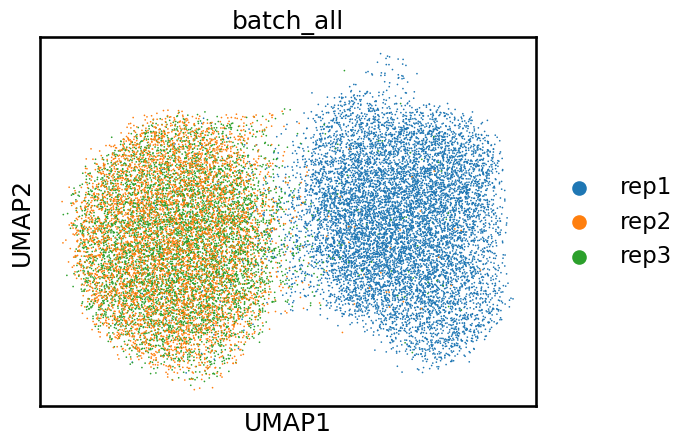

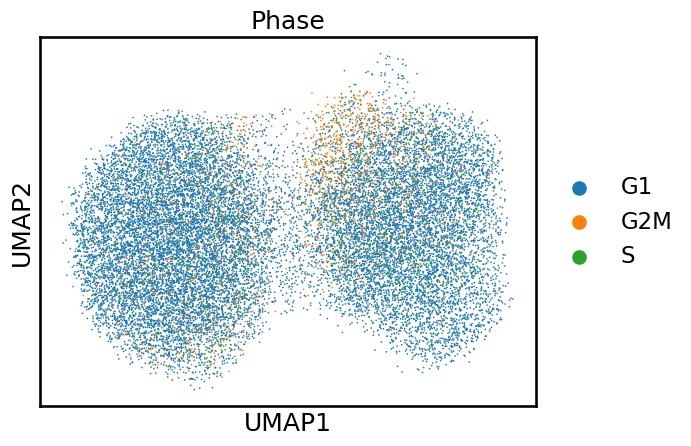

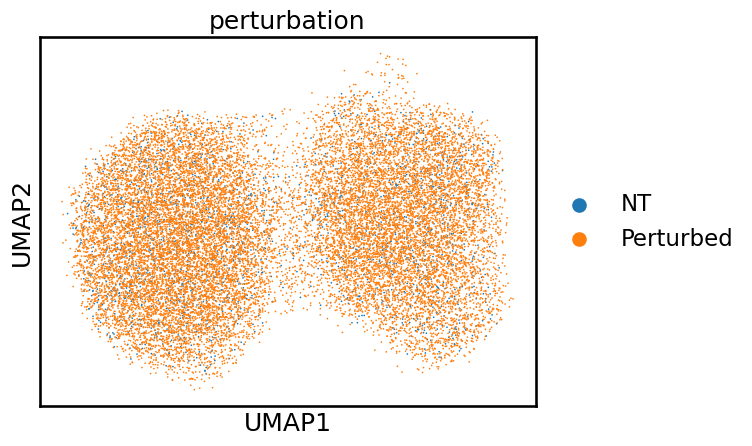

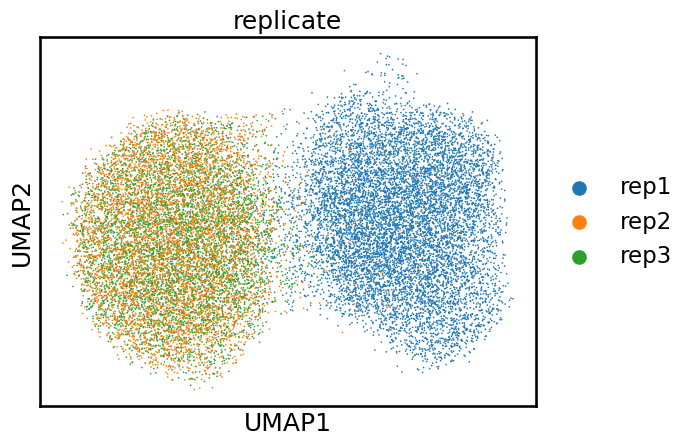

------------------------------
Evaluating ASD101
batch_all_denoise ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '2' '3' '4' '5' '6' '7'
 '8' '9']
batch_all_with_condition_denoise ['10__mutated' '10__nan' '11__mutated' '11__nan' '12__mutated' '12__nan'
 '13__mutated' '13__nan' '14__mutated' '14__nan' '15__mutated' '15__nan'
 '16__mutated' '16__nan' '17__mutated' '18__mutated' '18__nan'
 '1__mutated' '1__nan' '2__mutated' '2__nan' '3__mutated' '3__nan'
 '4__mutated' '4__nan' '5__mutated' '5__nan' '6__mutated' '6__nan'
 '7__mutated' '7__nan' '8__mutated' '8__nan' '9__mutated' '9__nan']
['Ces2a', 'Gm12862', 'Gm29295', 'Gm6763', 'Gm15325', 'Enam', 'Krt4', '4930486F22Rik', 'Usp17lc', 'B020011L13Rik', 'Noxa1', 'Tex21', 'Gm26581', 'Cd8a', 'Olfr1505', 'Vmn1r21', 'Mat1a', 'Gm7097', 'Gm15199', 'Doxl2', 'Nkx2-9', 'Neurog3', 'Tcf21', 'Speer4d', '4930455H04Rik', 'Zfp616', 'Gh', 'Gm7298', 'Gm14135', '4930465M20Rik', 'Gm29017', 'Drd3', '1700015E13Rik', '1700109G15Rik', 'Gm29554', 'Eppin', 'Tmem52

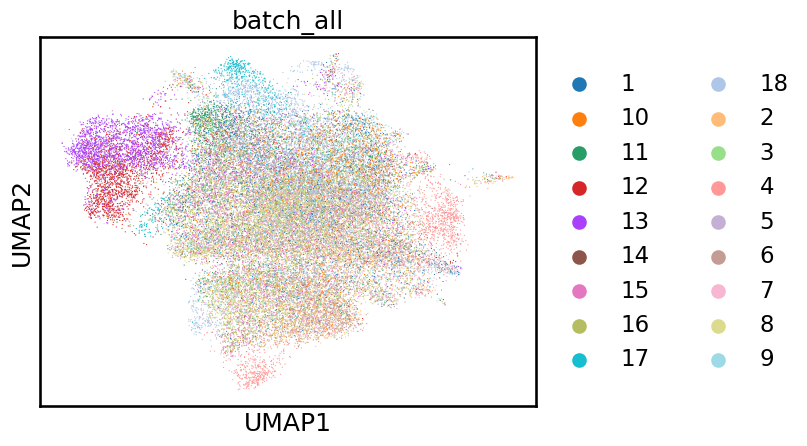

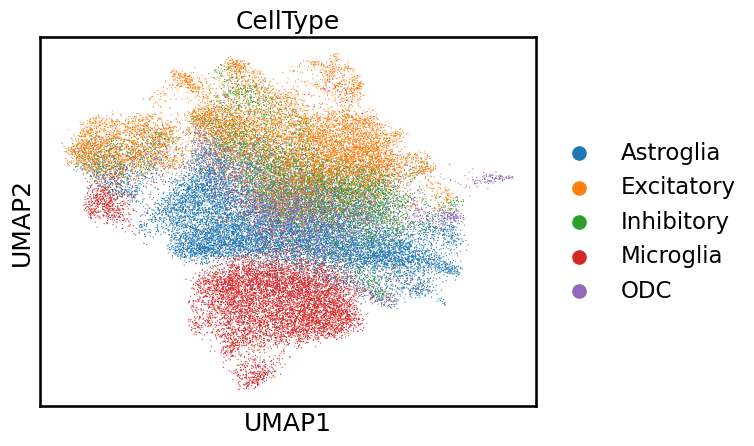

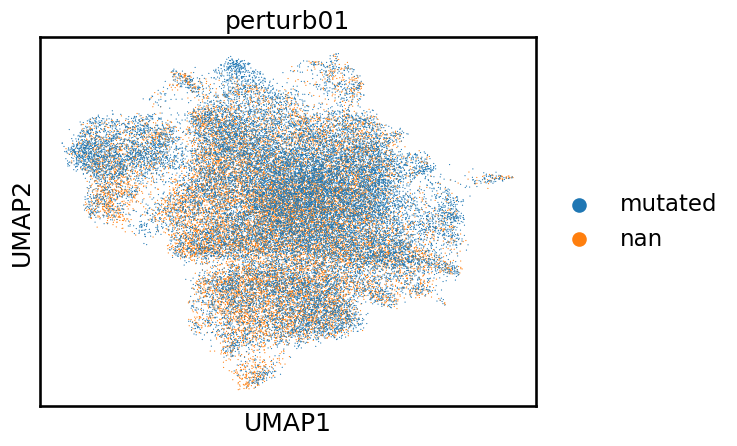

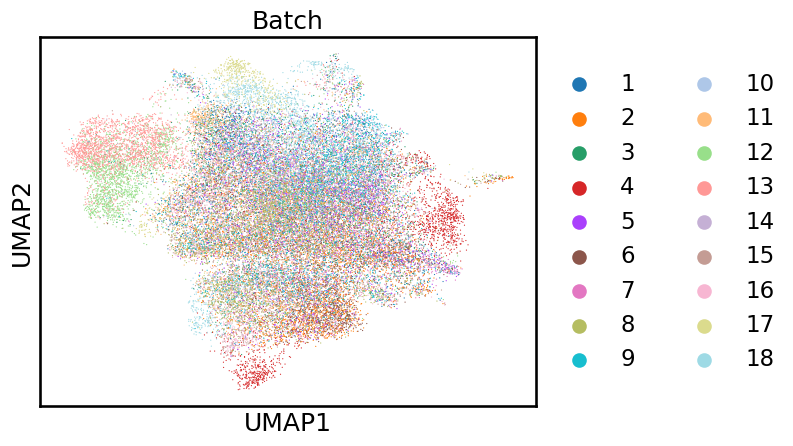

------------------------------


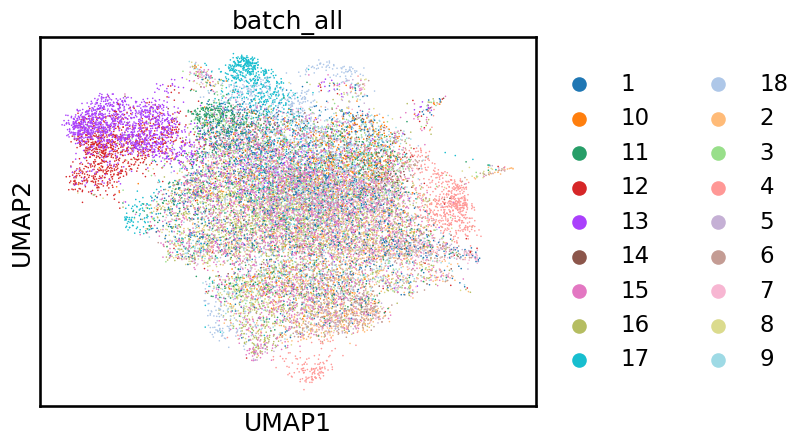

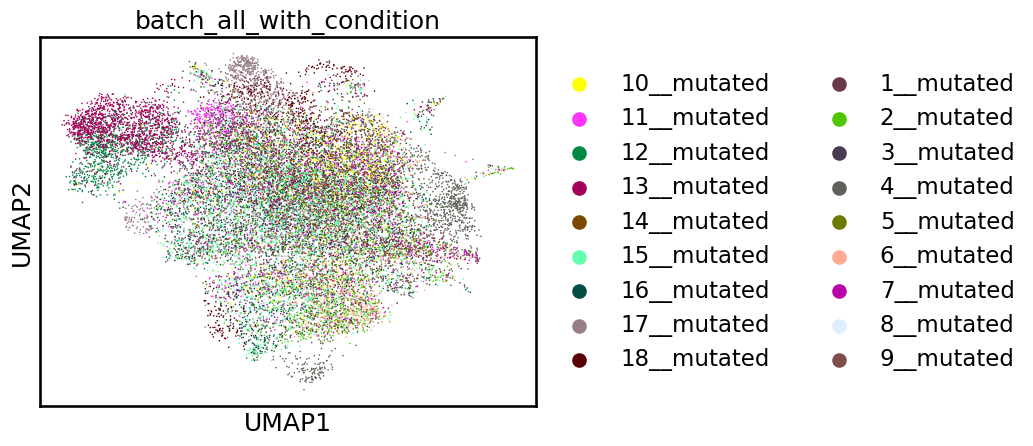

--------------------
Now evaluating nan denoised expression


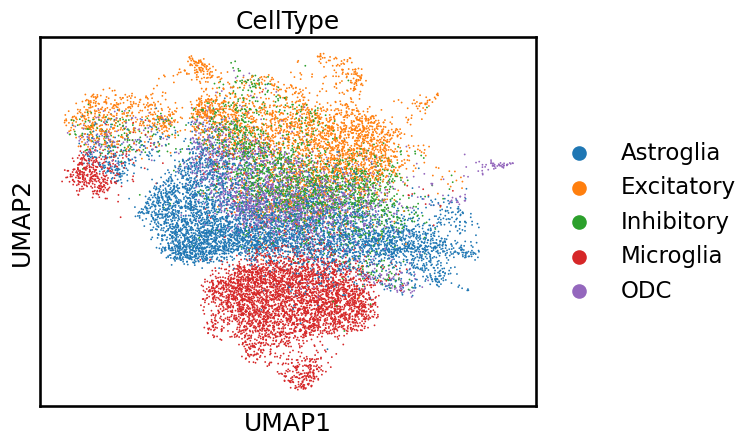

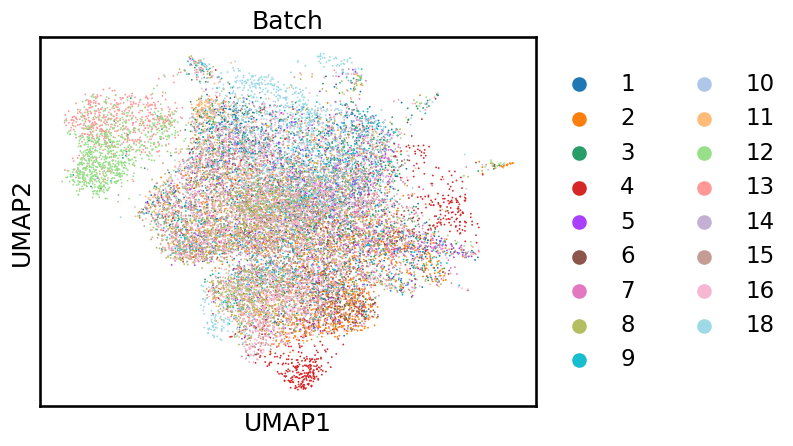

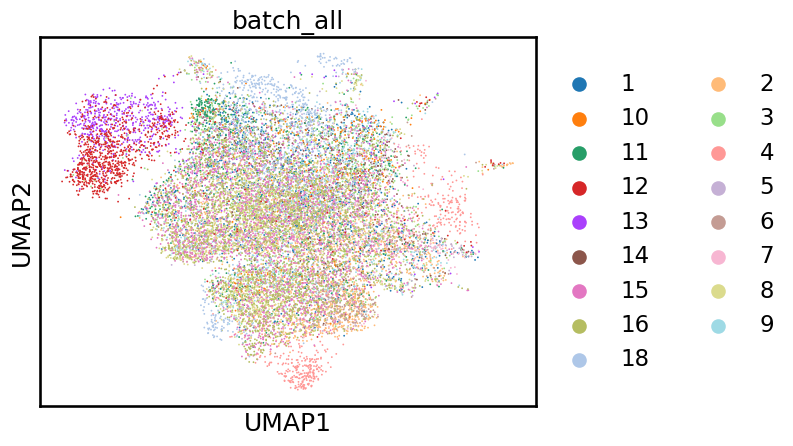

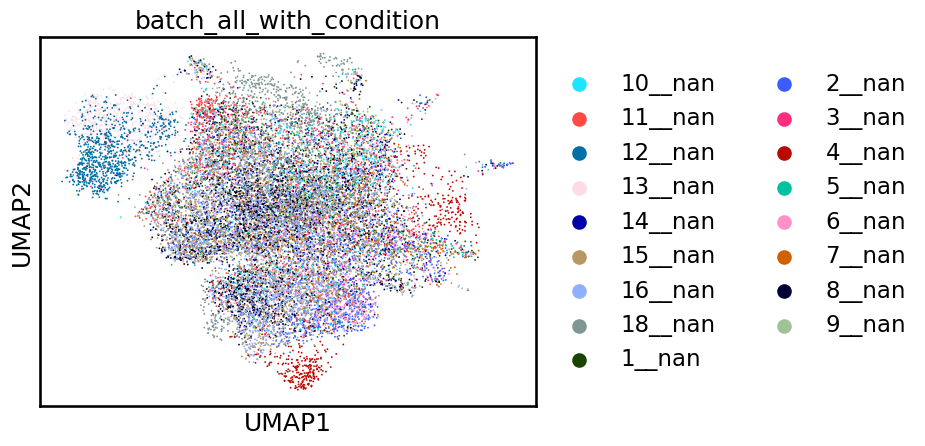

--------------------
------------------------------


In [18]:
for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    print("Evaluating",dataset_name)
    plot_batch_effect_ndreamer(dataset_name=dataset_name,cell_type_key=cell_type_keys[i],batch_key=batch_keys[i],condition_key=condition_keys[i])
    print("-"*30)